# Modello di Classificazione dei Pezzi Difettosi — AutomaParts S.p.A.

## Contesto Aziendale

**AutomaParts S.p.A.** è un fornitore tier-1 per il settore automotive che produce componenti meccanici di precisione per sistemi sterzo e sospensioni.  
In linea di produzione vengono misurate diverse caratteristiche per ogni pezzo (diametri, planarità, coppia, temperatura processo, ecc.).  
Alcuni pezzi non rispettano le tolleranze e causano fermi macchina o richiami cliente.

## Obiettivo

Sviluppare un modello di **Machine Learning supervisionato** che distingua pezzi conformi (`defect_label = 0`) da pezzi difettosi (`defect_label = 1`) per:
- **Scarto automatico** o blocco in ispezione finale
- **Instradamento a controllo 100%** quando la probabilità è incerta
- **Analisi delle cause principali** dei difetti per interventi di processo

## Pipeline di lavoro

1. Caricamento e prima esplorazione del dataset
2. Analisi esplorativa (EDA)
3. Pulizia dei dati
4. Preparazione delle variabili (encoding, feature engineering, scaling)
5. Addestramento di tre modelli: Logistic Regression, Decision Tree, Random Forest
6. Gestione dello sbilanciamento delle classi
7. Valutazione e confronto (metriche, confusion matrix, cross-validation, ROC, feature importance)
8. Conclusioni e raccomandazioni operative

In [1]:
# IMPORT — Tutte le librerie necessarie in un unico blocco

# Manipolazione dati
import pandas as pd     # Gestione di tabelle e dati strutturati (il "motore" per manipolare i CSV)
import numpy as np      # Fondamentale per calcoli numerici e gestione di array/matrici

# Visualizzazione
import matplotlib.pyplot as plt # La libreria base per creare grafici e diagrammi
import seaborn as sns           # Estensione di matplotlib per visualizzazioni statistiche più eleganti

# Pre-processing
from sklearn.preprocessing import StandardScaler, LabelEncoder # Per normalizzare i dati e convertire variabili testuali in numeri

# Modelli
from sklearn.linear_model import LogisticRegression    # Algoritmo lineare per classificazione binaria (facile e veloce)
from sklearn.tree import DecisionTreeClassifier         # Modello basato su "alberi" di decisione logicamente interpretabili
from sklearn.ensemble import RandomForestClassifier     # Una "foresta" di alberi che migliora precisione e robustezza

# Valutazione
from sklearn.model_selection import train_test_split, cross_val_score # Per dividere i dati e testare quanto il modello è stabile
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, # Metriche standard per misurare il successo del modello
    confusion_matrix, classification_report,                 # Per analizzare dove il modello sbaglia (falsi positivi/negativi)
    roc_curve, auc                                           # Per valutare la capacità del modello di distinguere le classi
)

---
## 1. Caricamento e Prima Esplorazione

Carichiamo il dataset `parts_production_data.csv` e verifichiamo dimensioni, tipi di dato e statistiche descrittive per avere un primo quadro della situazione.

In [2]:
# Caricamento del CSV in un DataFrame pandas
df = pd.read_csv('parts_production_data.csv')

# Prime 5 righe per un'anteprima visuale dei dati
df.head()

,part_id,production_timestamp,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label
0,1,2024-06-13 17:42:45,2,1,5,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,MB-2024W24-L02-575,0.602019,1
1,2,2024-07-26 10:36:48,9,14,4,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,MB-2024W30-L09-100,0.092746,0
2,3,2025-12-08 17:35:40,6,20,5,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,MB-2025W50-L06-297,0.227898,0
3,4,2024-12-09 12:56:36,4,4,7,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,MB-2024W50-L04-747,0.171139,0
4,5,2025-09-08 15:54:15,8,13,5,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,MB-2025W37-L08-470,0.914548,1


### Struttura del Dataset

| Variabile | Tipo | Descrizione |
|-----------|------|-------------|
| `part_id` | ID | Identificativo univoco del pezzo |
| `production_timestamp` | Datetime | Data/ora di produzione |
| `line_id` | Categorica | Linea produttiva (1-10) |
| `station_id` | Categorica | Stazione di misura (1-20) |
| `operator_id` | Categorica | Operatore (anonimizzato, 1-10) |
| `measure_diam_mm` | Numerica | Diametro (mm) |
| `measure_length_mm` | Numerica | Lunghezza (mm) |
| `flatness_mm` | Numerica | Planarità superficiale (mm) |
| `torque_Nm` | Numerica | Coppia registrata (Nm) |
| `surface_roughness_Ra` | Numerica | Rugosità superficiale (Ra) |
| `temp_process_C` | Numerica | Temperatura processo (°C) |
| `vibration_level` | Numerica | Livello vibrazione (0-1) |
| `cycle_time_s` | Numerica | Tempo ciclo (s) |
| `material_batch` | Categorica | Lotto materia prima |
| `visual_inspection_score` | Numerica | Punteggio ispezione visiva (0-1) |
| `defect_label` | Target | Etichetta binaria (0 = conforme, 1 = difettoso) |

**Variabili di identificazione e contesto:**  
`part_id` è l'identificativo univoco del singolo pezzo e non ha valore predittivo. `production_timestamp` registra il momento esatto della produzione e può essere utile per estrarre informazioni temporali (turno, ora del giorno). `line_id`, `station_id` e `operator_id` rappresentano rispettivamente la linea produttiva, la stazione di misura e l'operatore coinvolto: servono a tracciare eventuali pattern legati a specifiche combinazioni di macchina/turno/persona. `material_batch` identifica il lotto di materia prima utilizzato — variazioni tra lotti possono influenzare la qualità del prodotto finito.

**Misure dimensionali e di processo:**  
`measure_diam_mm` e `measure_length_mm` sono misure dimensionali dirette del pezzo (diametro e lunghezza in millimetri), fondamentali per verificare il rispetto delle tolleranze meccaniche. `flatness_mm` misura la planarità superficiale: valori elevati indicano deformazioni che possono compromettere l'accoppiamento del componente. `torque_Nm` è la coppia di serraggio registrata durante l'assemblaggio, un parametro critico per la sicurezza nei sistemi sterzo e sospensioni.

**Sensori e parametri di processo:**  
`surface_roughness_Ra` misura la rugosità superficiale secondo uno standard: Ra — influisce sull'attrito e sulla durata del componente. `temp_process_C` è la temperatura del processo produttivo in gradi Celsius: temperature fuori range possono alterare le proprietà del materiale. `vibration_level` (normalizzato 0-1) rileva vibrazioni anomale della macchina, potenziale indicatore di usura utensile o disallineamento. `cycle_time_s` è il tempo ciclo in secondi: tempi anomali possono segnalare problemi di processo.

**Ispezione e target:**  
`visual_inspection_score` (0-1) è il punteggio assegnato dall'ispezione visiva automatica o manuale — un valore basso indica probabilmente difetti estetici o superficiali. `defect_label` è la nostra **variabile target** binaria: 0 indica un pezzo conforme, 1 un pezzo difettoso che non ha superato i controlli qualità.

In [3]:
# Dimensioni del dataset e tipi di dato per ogni colonna
print("Dimensione del dataset:", df.shape)
df.info()

Dimensione del dataset: (3000, 16)
<class 'pandas.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   part_id                  3000 non-null   int64  
 1   production_timestamp     3000 non-null   str    
 2   line_id                  3000 non-null   int64  
 3   station_id               3000 non-null   int64  
 4   operator_id              3000 non-null   int64  
 5   measure_diam_mm          3000 non-null   float64
 6   measure_length_mm        3000 non-null   float64
 7   flatness_mm              3000 non-null   float64
 8   torque_Nm                3000 non-null   float64
 9   surface_roughness_Ra     3000 non-null   float64
 10  temp_process_C           3000 non-null   float64
 11  vibration_level          3000 non-null   float64
 12  cycle_time_s             3000 non-null   float64
 13  material_batch           3000 non-null   str    
 14  

**Commento:** Notiamo subito che `production_timestamp` e `material_batch` sono di tipo stringa. Il timestamp andrà convertito in formato datetime per estrarne informazioni temporali, mentre `material_batch` è una variabile categorica ad alta cardinalità che richiederà un ulteriore lavorazione e/o un encoding numerico.

In [4]:
# Statistiche descrittive per le variabili numeriche:
# media, deviazione standard, min, max e quartili
df.describe()

,part_id,line_id,station_id,operator_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,visual_inspection_score,defect_label
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,5.548000,10.632333,5.497000,30.260599,49.707794,29.82437,302.045475,29.888010,110.732378,0.496433,200.483076,0.498166,0.224333
std,866.169729,2.824834,5.808362,2.868693,11.406951,11.536161,5.79796,115.859112,11.638858,23.244585,0.286117,57.751629,0.286271,0.417212
min,1.000000,1.000000,1.000000,1.000000,10.014000,30.005000,20.00300,100.085000,10.000000,70.006000,0.000092,100.094000,0.000051,0.000000
25%,750.750000,3.000000,5.750000,3.000000,20.642750,39.667250,24.74375,201.608500,19.955250,90.624750,0.253753,149.543750,0.249152,0.000000
50%,1500.500000,6.000000,11.000000,6.000000,30.277000,49.450500,29.79500,303.522000,29.670000,111.266000,0.495252,200.839500,0.510032,0.000000
75%,2250.250000,8.000000,16.000000,8.000000,39.927750,59.595000,34.84550,400.808000,40.269250,131.194250,0.744657,250.876750,0.743558,0.000000
max,3000.000000,10.000000,20.000000,10.000000,49.997000,69.986000,39.99400,499.619000,49.959000,149.968000,0.999678,299.995000,0.999857,1.000000


**Commento:** La tabella `describe()` ci fornisce un colpo d'occhio su valori medi, minimi, massimi e distribuzione (quartili) di ogni variabile numerica. Ci serve per individuare subito eventuali valori anomali — per esempio una temperatura fuori range o un diametro implausibile. A prima vista, i dati sembrano coerenti: le medie e i range non presentano anomalie evidenti.

1. count (Conteggio)
Indica il numero di valori non nulli presenti nella colonna.
2. mean (Media)
È la media aritmetica dei valori (la somma di tutti i numeri divisa per il loro numero).
3. std (Deviazione Standard)
Indica quanto i dati sono "sparpagliati" rispetto alla media.
4. min (Minimo)
Il valore più piccolo registrato in quella colonna.
5. 25% (Primo Quartile o Q1)
Indica il valore sotto il quale si trova il 25% dei dati.
6. 50% (Mediana o Secondo Quartile)
È il valore centrale della distribuzione: metà dei dati sono più piccoli di questo numero, metà sono più grandi.
7. 75% (Terzo Quartile o Q3)
Indica il valore sotto il quale si trova il 75% dei dati.
8. max (Massimo)
Il valore più grande registrato in quella colonna.

---
## 2. Analisi Esplorativa (EDA)

Esploriamo la distribuzione della variabile target, la ripartizione dei difetti per linea produttiva e le correlazioni tra le variabili numeriche.

### 2.1 Distribuzione della variabile target

Verifichiamo quanti pezzi risultano difettosi rispetto a quelli conformi. Lo sbilanciamento delle classi è un aspetto critico perché può ingannare le metriche di valutazione.

defect_label
0    2327
1     673
Name: count, dtype: int64


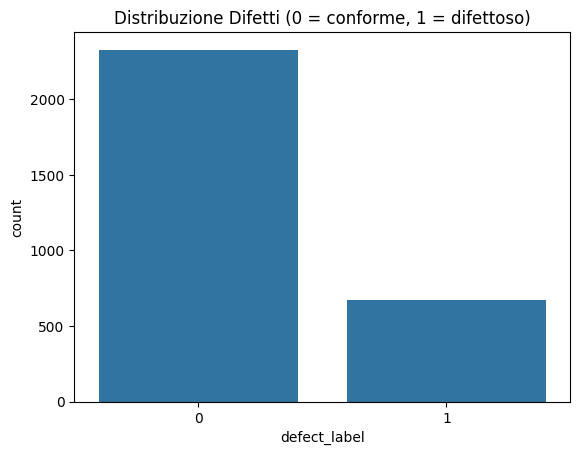

In [5]:
# Conteggio pezzi conformi (0) e difettosi (1)
print(df['defect_label'].value_counts())

# Grafico a barre per visualizzare lo sbilanciamento
sns.countplot(x='defect_label', data=df)
plt.title('Distribuzione Difetti (0 = conforme, 1 = difettoso)')
plt.show()

**Commento:** Come atteso in una linea produttiva reale, i pezzi difettosi sono una **minoranza** rispetto a quelli conformi. Questo sbilanciamento è normale (altrimenti la linea sarebbe fuori controllo), ma ha un impatto diretto sui modelli: un classificatore potrebbe "barare" predicendo sempre la classe maggioritaria e ottenere comunque un'accuratezza elevata. Ne terremo conto nella fase di modellazione con tecniche di bilanciamento.

### 2.2 Difetti per linea e stazione produttiva

Analizziamo se alcune linee o stazioni produttive presentano un tasso di difettosità più alto di altre. Informazione utile per gli stakeholder e per interventi mirati. Non visualizziamo `material_batch` (~3000 lotti) perché un grafico a barre con migliaia di categorie sarebbe illeggibile.

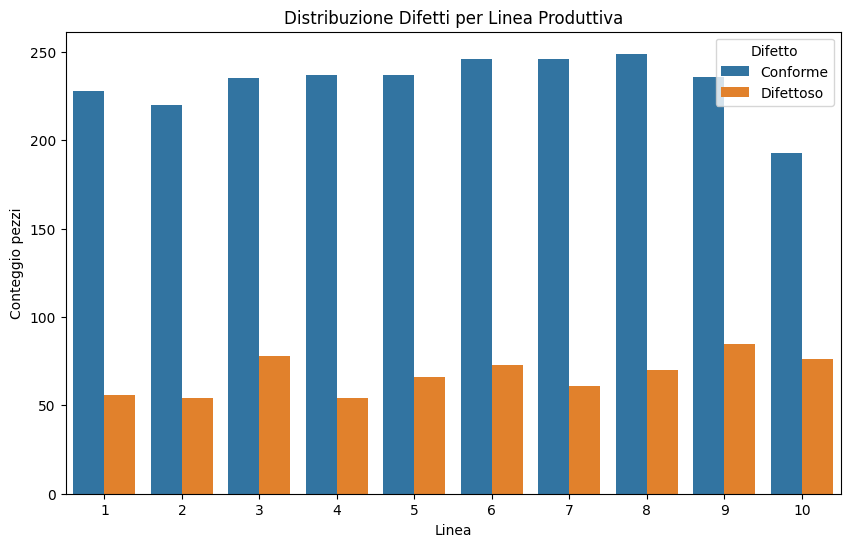

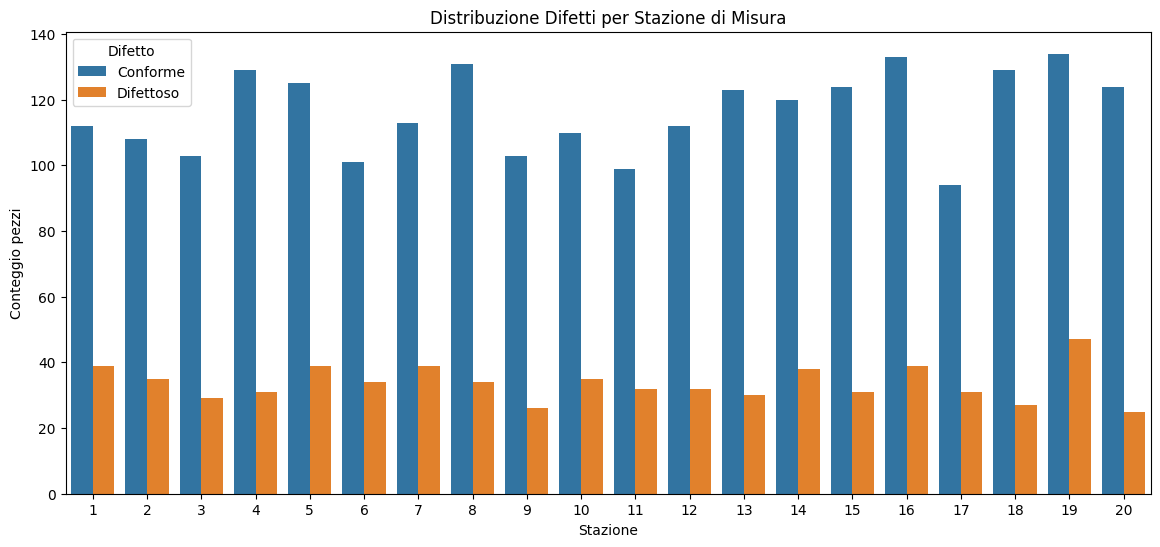

In [6]:
# Countplot difetti per LINEA produttiva

# Definisce dimensioni grafico
plt.figure(figsize=(10, 6))
# Analizza la distribuzione dei difetti per ogni linea di produzione (line_id)
# Il parametro 'hue' permette di confrontare visivamente pezzi conformi e difettosi tra le diverse linee
sns.countplot(x="line_id", hue="defect_label", data=df) 
# Formattazione grafico
plt.title("Distribuzione Difetti per Linea Produttiva")
plt.xlabel("Linea")
plt.ylabel("Conteggio pezzi")
plt.legend(title="Difetto", labels=["Conforme", "Difettoso"])
# Disegna il grafico
plt.show()

# Countplot difetti per STAZIONE di misura

# Definisce dimensioni grafico
plt.figure(figsize=(14, 6))
# Analizza la distribuzione dei difetti per ogni linea di produzione (station_id)
# Il parametro 'hue' permette di confrontare visivamente pezzi conformi e difettosi tra le diverse linee
sns.countplot(x="station_id", hue="defect_label", data=df)
# Formattazione grafico
plt.title("Distribuzione Difetti per Stazione di Misura")
plt.xlabel("Stazione")
plt.ylabel("Conteggio pezzi")
plt.legend(title="Difetto", labels=["Conforme", "Difettoso"])
# Disegna il grafico
plt.show()

**Commento:** Le proporzioni tra pezzi conformi e difettosi sono piuttosto uniformi sia tra le diverse linee che tra le stazioni di misura: nessuna si distingue in modo evidente per un tasso di difettosità anomalo. Questo suggerisce che i difetti non sono legati a una specifica linea o stazione ma probabilmente a fattori trasversali (materiali, parametri di processo, condizioni operative).

### 2.3 Matrice di Correlazione

Verifichiamo se esistono correlazioni forti tra le variabili numeriche e con il target `defect_label`. Variabili molto correlate tra loro o con il target possono guidare la scelta delle feature.

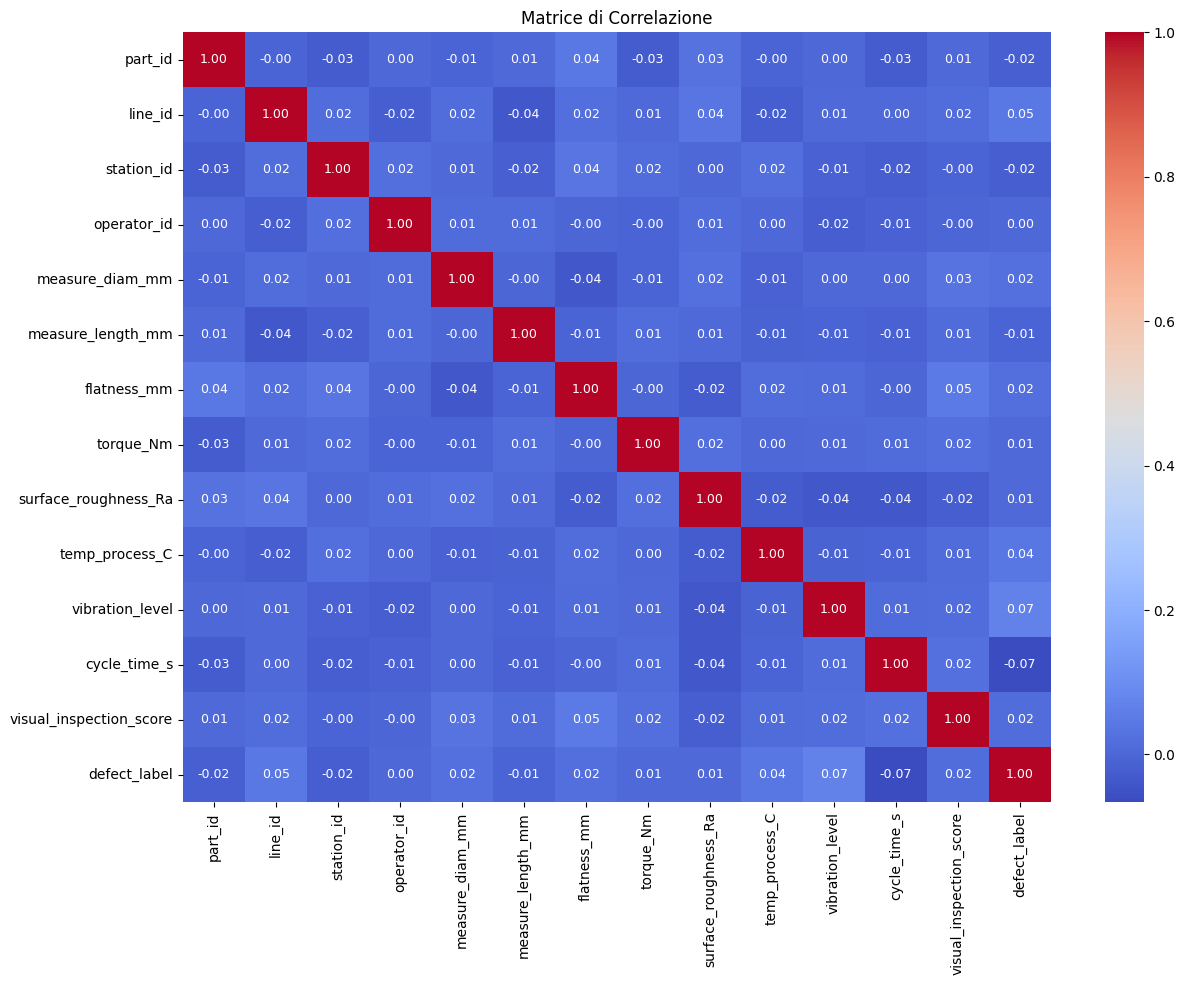

In [7]:
# Heatmap delle correlazioni — valori tra -1 (correlazione negativa) e +1 (correlazione positiva)
# Definiamo dimensioni grafico
plt.figure(figsize=(14, 10))
# Calcoliamo la Matrice di Correlazione e definiamo alcuni parametri
sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,
    fmt=".2f",             # Due decimali per leggibilità
    annot_kws={"size": 9}, # Font ridotto per evitare sovrapposizioni
    cmap='coolwarm'
)
plt.title('Matrice di Correlazione')
plt.show()

**Commento:** Questo grafico ci dice se le variabili sono "amiche" e si influenzano a vicenda. Vediamo che è quasi tutto blu, con valori molti vicino allo 0: significa che i dati sono molto indipendenti tra loro.In pratica, non c'è una "variabile magica" che da sola ci dice se il pezzo è difettoso.

---
## 3. Pulizia dei Dati

C'è un po' di lavoro da fare per pulire i dati e prepararli per il modello.

Verifichiamo la presenza di valori mancanti, trattiamo eventuali outlier e rimuoviamo le colonne non informative o sensibili sotto il profilo privacy.

### 3.1 Valori Mancanti

In [8]:
# Conteggio dei valori nulli per ogni colonna
df.isnull().sum()

part_id                    0
production_timestamp       0
line_id                    0
station_id                 0
operator_id                0
measure_diam_mm            0
measure_length_mm          0
flatness_mm                0
torque_Nm                  0
surface_roughness_Ra       0
temp_process_C             0
vibration_level            0
cycle_time_s               0
material_batch             0
visual_inspection_score    0
defect_label               0
dtype: int64

**Commento:** Il dataset non presenta **alcun valore mancante**: tutte le colonne hanno il conteggio completo di osservazioni. Non è quindi necessario applicare strategie di rimozione di righe incomplete. Un ottimo punto di partenza.

### 3.2 Controllo Outlier (metodo IQR)

Applichiamo il metodo dell'**Interquartile Range (IQR)** sulle principali variabili di processo per verificare la presenza di valori anomali. Un valore è considerato outlier se cade al di sotto di Q1 − 1.5·IQR o al di sopra di Q3 + 1.5·IQR.

Abbiamo scelto le feature che sono dati "continui" e che possono presentare errori di lettura o anomalie estreme che sporcherebbero il modello. 

In [9]:
# Creiamo una funzione per trovare ed eliminare i "valori pazzi" (outlier)
def remove_outliers_iqr(df, column):
    # Calcoliamo il 25% (punto basso) e il 75% (punto alto) dei dati
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calcoliamo la distanza tra questi due punti (l'intervallo centrale)
    IQR = Q3 - Q1
    
    # Definiamo i confini: oltre questa "recinzione" il dato è considerato un errore
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Teniamo solo i dati che stanno dentro i confini
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Stampiamo quante righe abbiamo inizialmente
print(f"Righe PRIMA della pulizia: {len(df)}")

# Scegliamo solo le variabili numeriche dei sensori e delle misure fisiche
cols_to_clean = ['measure_diam_mm', 'measure_length_mm', 'temp_process_C', 'vibration_level']

# Applichiamo la pulizia colonna per colonna
for col in cols_to_clean:
    df = remove_outliers_iqr(df, col)

# Verifichiamo quante righe sono rimaste (se ne abbiamo perse troppe, il filtro era troppo severo)
print(f"Righe DOPO la pulizia:  {len(df)}")

Righe PRIMA della pulizia: 3000
Righe DOPO la pulizia:  3000


**Commento:** Il conteggio delle righe prima e dopo la pulizia è identico: **nessun sample è stato eliminato**. Questo conferma quanto osservato dal `describe()` iniziale: i dati rientrano tutti in range ragionevoli e non presentano outlier significativi secondo il criterio IQR.

### 3.3 Rimozione colonne non informative e privacy

- **`part_id`**: è un identificativo univoco progressivo, non porta informazione predittiva.
- **`operator_id`**: potrebbe essere coperto da vincoli di privacy aziendale; inoltre, dal grafico di sez. 2.2 non emergeva un legame operatore↔difetto particolarmente forte. Lo rimuoviamo per cautela.
- **`production_timestamp`**: prima di eliminarlo, estraiamo l'**ora di produzione** — potrebbe influenzare la qualità (es. turni, stanchezza).

In [10]:
# Controlliamo se la colonna esiste ancora prima di lavorarci
if 'production_timestamp' in df.columns:
    # Conversione del timestamp
    df['production_timestamp'] = pd.to_datetime(df['production_timestamp'])

    # Estraiamo l'ora
    df['hour'] = df['production_timestamp'].dt.hour

    # Rimozione colonne: ora possiamo farlo tranquillamente
    df = df.drop(columns=['part_id', 'production_timestamp', 'operator_id'], errors='ignore')
    print("Trasformazione completata con successo.")
else:
    print("La colonna 'production_timestamp' è già stata rimossa o trasformata.")

print("\nColonne finali nel dataset:")
for col in df.columns:
    print(f"- {col}")

# Prime 5 righe per un'anteprima visuale dei dati
df.head()

Trasformazione completata con successo.

Colonne finali nel dataset:
- line_id
- station_id
- measure_diam_mm
- measure_length_mm
- flatness_mm
- torque_Nm
- surface_roughness_Ra
- temp_process_C
- vibration_level
- cycle_time_s
- material_batch
- visual_inspection_score
- defect_label
- hour


,line_id,station_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label,hour
0,2,1,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,MB-2024W24-L02-575,0.602019,1,17
1,9,14,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,MB-2024W30-L09-100,0.092746,0,10
2,6,20,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,MB-2025W50-L06-297,0.227898,0,17
3,4,4,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,MB-2024W50-L04-747,0.171139,0,12
4,8,13,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,MB-2025W37-L08-470,0.914548,1,15


**Commento:** Abbiamo ridotto il dataset alle sole colonne utili e aggiunto la feature `hour`. Il DataFrame ora contiene solo variabili che porteranno informazione ai modelli, rispettando inoltre i requisiti di privacy sull'operatore.

---
## 4. Preparazione delle Variabili

In questa sezione estraiamo informazioni dalla colonna `material_batch`, trasformiamo le variabili categoriche in formato numerico, e applichiamo lo scaling.

### 4.1 Feature Engineering: Material Batch Analysis

Estraiamo informazioni utili dalla colonna `material_batch` (formato `MB-YYYYWww-Lnn-sss`) per arricchire il dataset, mantenendo comunque la colonna originale per le aggregazioni successive.

**Cosa estraiamo:**
- **Anno (`batch_year`)**: utile per identificare trend di lungo periodo (es. invecchiamento macchinari).
- **Settimana (`batch_week`)**: convertita poi in Seno/Coseno per catturare la stagionalità (es. temperatura esterna, cicli di manutenzione).
- **Sequenza (`batch_seq`)**: il numero progressivo del lotto, fondamentale per intercettare derive temporali rapide.
- **Linea (`batch_line_check`)**: estratta solo per validare la coerenza con la colonna `line_id`.

**Nota importante:**
La colonna originale `material_batch` **NON viene eliminata**. La manteniamo codificata (LabelEncoder) perché è essenziale per calcolare le *deviazioni* (sezione successiva), ovvero quanto un pezzo differisce dalla media del suo specifico lotto di produzione.

In [11]:
# Definizione di una funzione per "smontare" il codice del lotto (es. MB-2024W24-L02-575)
def extract_batch_info(batch_str):
    try:
        # Dividiamo la stringa usando il trattino '-' come separatore
        parts = batch_str.split('-')
        
        # Se non otteniamo 4 parti, il codice è scritto male e saltiamo la riga
        if len(parts) != 4:
            return None, None, None, None
        
        # La seconda parte (parts[1]) è '2024W24'. La dividiamo alla 'W'
        year_week = parts[1].split('W')
        year = int(year_week[0])  # Otteniamo l'anno (es. 2024)
        week = int(year_week[1])  # Otteniamo la settimana (es. 24)
        
        # La terza parte (parts[2]) è 'L02'. Togliamo la 'L' e prendiamo il numero
        line_id = int(parts[2][1:]) 
        
        # L'ultima parte (parts[3]) è il numero progressivo (es. 575)
        seq = int(parts[3])
        
        # Restituiamo i 4 valori pronti per essere salvati
        return year, week, line_id, seq
    except:
        # In caso di errori imprevisti, restituiamo valori vuoti per non bloccare il codice
        return None, None, None, None

# Applichiamo la funzione a tutta la colonna 'material_batch'
# Il risultato è una colonna temporanea di "pacchetti" contenenti i 4 dati sopra
batch_data = df['material_batch'].apply(extract_batch_info)

# "Sballiamo" i pacchetti e creiamo le nuove colonne nel dataset principale
df['batch_year'] = batch_data.apply(lambda x: x[0])  # Estrae l'anno
df['batch_week'] = batch_data.apply(lambda x: x[1])  # Estrae la settimana
df['batch_line_check'] = batch_data.apply(lambda x: x[2]) # Estrae la linea (per controllo)
df['batch_seq'] = batch_data.apply(lambda x: x[3])   # Estrae la sequenza

# CONTROLLO QUALITÀ DATI: 
# Verifichiamo se la linea estratta dal codice lotto coincide con la colonna 'line_id' già presente
mismatches = df[df['line_id'] != df['batch_line_check']]
print(f"Discrepanze trovate tra Line ID e codice Batch: {len(mismatches)}")

# Se i dati sono coerenti (0 errori), cancelliamo la colonna di controllo perché sarebbe un doppione
if len(mismatches) == 0:
    print("Dati coerenti. Rimuovo la colonna batch_line_check.")
    df.drop(columns=['batch_line_check'], inplace=True)
else:
    print("ATTENZIONE: Ci sono differenze nei dati! Indaga prima di proseguire.")

# TRASFORMAZIONE CICLICA:
# Trasformiamo la settimana in coordinate Seno e Coseno.
# Questo serve a far capire al computer che la settimana 52 e la settimana 1 sono "vicine" nel tempo (inverno).
df['batch_week_sin'] = np.sin(2 * np.pi * df['batch_week'] / 53)
df['batch_week_cos'] = np.cos(2 * np.pi * df['batch_week'] / 53)

print("Operazione completata! Nuove colonne create per l'analisi temporale.")
df.head()

Discrepanze trovate tra Line ID e codice Batch: 0
Dati coerenti. Rimuovo la colonna batch_line_check.
Operazione completata! Nuove colonne create per l'analisi temporale.


,line_id,station_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label,hour,batch_year,batch_week,batch_seq,batch_week_sin,batch_week_cos
0,2,1,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,MB-2024W24-L02-575,0.602019,1,17,2024,24,575,0.292057,-0.956401
1,9,14,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,MB-2024W30-L09-100,0.092746,0,10,2024,30,100,-0.403123,-0.915146
2,6,20,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,MB-2025W50-L06-297,0.227898,0,17,2025,50,297,-0.348202,0.937420
3,4,4,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,MB-2024W50-L04-747,0.171139,0,12,2024,50,747,-0.348202,0.937420
4,8,13,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,MB-2025W37-L08-470,0.914548,1,15,2025,37,470,-0.947326,-0.320270


**Commento**: Abbiamo trasformato il testo complicato del lotto in numeri pronti per l'analisi. Ora il computer può 'vedere' l'anno, la settimana e la sequenza di produzione, aiutandolo a capire se i difetti dipendono dal periodo dell'anno o da quanto tempo la macchina sta lavorando.

### 4.2 Encoding delle variabili categoriche (LabelEncoder)

Il dataset contiene variabili categoriche di tipo stringa che i modelli non possono usare direttamente. Utilizziamo il **LabelEncoder** di scikit-learn, che assegna un numero intero univoco a ogni categoria. Per `material_batch`, che ha un'alta cardinalità (~3000 lotti diversi), il LabelEncoder è la scelta più pratica: usare `get_dummies` genererebbe migliaia di colonne.

Sebbene abbiamo già estratto dati utili per questa colonna `material_batch` (che contiene migliaia di lotti diversi), fare anche il LabelEncoder è fondamentale: ci permette di mantenere l'identità unica di ogni lotto senza appesantire il dataset con migliaia di nuove colonne. In questo modo il modello potrà distinguere i singoli lotti usando un semplice codice numerico. 


In [12]:
# Verifica della cardinalità delle colonne categoriche
print("Batch unici:", df['material_batch'].nunique())
print("Line ID unici:", df['line_id'].nunique())

Batch unici: 2997
Line ID unici: 10


Se avessimo usato one-hot encoding su material_batch, avremmo effettivamente creato 2997 nuove colonne (una per ogni batch unico), rendendo il dataset enorme e il modello molto più complesso. Con il LabelEncoder il numero di colonne resta invariato.

* Batch unici: 2997 Significa che nel dataset ci sono 2.997 lotti di materiale differenti. È una cardinalità molto alta.
* Line ID unici: 10 Significa che l'intera produzione è distribuita su sole 10 linee di produzione fisiche diverse. È una cardinalità bassa. 

In [13]:
# Creiamo una copia del DataFrame: lavoriamo su 'df_encoded' per lasciare intatto quello originale
df_encoded = df.copy()

# Prepariamo l'attrezzo 'LabelEncoder' che traduce i testi in numeri (es: "Batch-A" -> 1)
le = LabelEncoder()

# Selezioniamo automaticamente solo le colonne che contengono testo (object o string)
# In questo dataset troverà sicuramente 'material_batch'
categorical_cols = df_encoded.select_dtypes(include=['object', 'string']).columns

# Cicliamo su ogni colonna testuale trovata
for col in categorical_cols:
    # Trasformiamo la colonna: fit_transform impara le categorie e le sostituisce con i numeri
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    # Stampiamo un feedback per sapere quante categorie diverse sono state numerate
    print(f"Codificata: {col} → {df_encoded[col].nunique()} valori unici")

print("\nEncoding completato.")

# Visualizziamo le prime righe del nuovo DataFrame "numerico" per verificare il risultato
# Noterai che material_batch ora contiene numeri interi invece dei codici MB-...
df_encoded.head()

Codificata: material_batch → 2997 valori unici

Encoding completato.


,line_id,station_id,measure_diam_mm,measure_length_mm,flatness_mm,torque_Nm,surface_roughness_Ra,temp_process_C,vibration_level,cycle_time_s,material_batch,visual_inspection_score,defect_label,hour,batch_year,batch_week,batch_seq,batch_week_sin,batch_week_cos
0,2,1,15.582,34.100,34.813,318.147,33.620,72.543,0.093695,146.532,717,0.602019,1,17,2024,24,575,0.292057,-0.956401
1,9,14,42.377,30.260,36.116,379.256,23.610,82.438,0.957213,167.319,899,0.092746,0,10,2024,30,100,-0.403123,-0.915146
2,6,20,25.141,52.082,36.588,347.408,44.468,116.188,0.704572,109.165,2948,0.227898,0,17,2025,50,297,-0.348202,0.937420
3,4,4,35.427,44.593,27.404,183.803,20.679,144.932,0.648035,221.826,1464,0.171139,0,12,2024,50,747,-0.348202,0.937420
4,8,13,22.618,40.710,24.220,477.164,45.055,95.174,0.655439,179.126,2615,0.914548,1,15,2025,37,470,-0.947326,-0.320270


In [14]:
# Visualizzazione dei valori encodati per material_batch e line_id
df_encoded[['material_batch', 'line_id']].head(10)

,material_batch,line_id
0,717,2
1,899,9
2,2948,6
3,1464,4
4,2615,8
5,2384,3
6,1710,7
7,1666,8
8,2697,10
9,1962,8


**Commento:** Tutte le colonne categoriche sono state trasformate in valori numerici interi. Da notare che `material_batch` ha un'alta cardinalità: il modello potrebbe tendere all'overfitting su questa variabile. Tuttavia, per gli scopi di questa esercitazione, il LabelEncoder è il compromesso più idoneo per confrontare la capacità di generalizzazione dei diversi algoritmi.

### 4.2 Feature Engineering — Deviazioni per lotto

Spesso un valore non è 'anomalo' in assoluto, ma lo è rispetto al gruppo di pezzi prodotti nello stesso momento con la stessa materia prima.

Calcoliamo le deviazioni dalla media del lotto per il diametro e la temperatura. Questo ci aiuta a capire se un pezzo è un 'outlier' all'interno della sua stessa famiglia (batch). Ad esempio: se un intero lotto viene prodotto a 100°C, un pezzo a 105°C è sospetto, anche se 105°C rientra nei limiti generali della fabbrica.

In [ ]:
# --- 1. ANALISI DEL DIAMETRO ---
# Calcoliamo la media del diametro per ogni singolo lotto e la spalmiamo su ogni riga del lotto corrispondente
df_encoded['batch_diam_mean'] = df_encoded.groupby('material_batch')['measure_diam_mm'].transform('mean')

# Calcoliamo quanto il pezzo singolo "sgarra" rispetto alla media dei suoi compagni di lotto
# Un valore positivo significa che è più grande della media, negativo che è più piccolo
df_encoded['diam_dev_from_batch'] = df_encoded['measure_diam_mm'] - df_encoded['batch_diam_mean']

# --- 2. ANALISI DELLA TEMPERATURA ---
# Facciamo la stessa cosa per la temperatura: raggruppiamo per lotto e troviamo la media
df_encoded['batch_temp_mean'] = df_encoded.groupby('material_batch')['temp_process_C'].transform('mean')

# Calcoliamo lo scostamento termico: il pezzo è stato prodotto più al caldo o al freddo rispetto al suo lotto?
# Questo serve a intercettare sbalzi improvvisi di temperatura durante la lavorazione
df_encoded['temp_dev_from_batch'] = df_encoded['temp_process_C'] - df_encoded['batch_temp_mean']

print("Feature engineering completato — aggiunte 4 colonne (2 medie + 2 deviazioni).")

# Visualizziamo le nuove colonne per capire il calcolo fatto solo per il diametro ma lo stesso è stato fatto per la temperatura
# Vedrai il valore originale, la media del suo gruppo e la differenza finale
df_encoded[['material_batch', 'measure_diam_mm', 'batch_diam_mean', 'diam_dev_from_batch']].head()

Feature engineering completato — aggiunte 4 colonne (2 medie + 2 deviazioni).


,material_batch,measure_diam_mm,batch_diam_mean,diam_dev_from_batch
0,717,15.582,15.582,0.0
1,899,42.377,42.377,0.0
2,2948,25.141,25.141,0.0
3,1464,35.427,35.427,0.0
4,2615,22.618,22.618,0.0


Perché proprio queste colonne?
* Diametro: È la misura critica. Una deviazione improvvisa dal batch indica che qualcosa è cambiato fisicamente (magari l'utensile si è scheggiato o il pezzo si è mosso).
* Temperatura: La temperatura esterna o del materiale cambia durante il giorno. La media del batch cattura la "normalità" del momento (es. fa caldo in tutta l'officina), mentre la deviazione cattura l'anomalia istantanea (es. un picco di calore solo su quel pezzo).


In [16]:
# Esempio: prime 10 righe con le nuove colonne
df_encoded[['material_batch', 'measure_diam_mm', 'batch_diam_mean', 'diam_dev_from_batch',
            'temp_process_C', 'batch_temp_mean', 'temp_dev_from_batch']].head(10)

,material_batch,measure_diam_mm,batch_diam_mean,diam_dev_from_batch,temp_process_C,batch_temp_mean,temp_dev_from_batch
0,717,15.582,15.582,0.0,72.543,72.543,0.0
1,899,42.377,42.377,0.0,82.438,82.438,0.0
2,2948,25.141,25.141,0.0,116.188,116.188,0.0
3,1464,35.427,35.427,0.0,144.932,144.932,0.0
4,2615,22.618,22.618,0.0,95.174,95.174,0.0
5,2384,33.383,33.383,0.0,110.762,110.762,0.0
6,1710,20.057,20.057,0.0,140.783,140.783,0.0
7,1666,46.505,46.505,0.0,82.227,82.227,0.0
8,2697,42.271,42.271,0.0,128.553,128.553,0.0
9,1962,26.926,26.926,0.0,94.937,94.937,0.0


**Commento:** Le nuove feature `diam_dev_from_batch` e `temp_dev_from_batch` rappresentano quanto un singolo pezzo si discosta dalla norma del proprio lotto. In un contesto produttivo reale, con molti pezzi per lotto, queste informazioni contestuali darebbero al modello un segnale più preciso rispetto ai valori assoluti.

**Osservazione importante:** Come si nota dalla tabella qui sopra, tutte le deviazioni risultano **0.0**. Questo accade perché nel nostro dataset ci sono **2997 batch unici su 3000 righe** — quasi ogni lotto contiene un solo pezzo. Quando si calcola la media di un gruppo con un solo elemento, la media coincide con il valore stesso, e la deviazione è inevitabilmente zero. Le colonne di feature engineering restano comunque nel dataset come esempio didattico dell'approccio, ma in questo caso specifico **non apportano informazione aggiuntiva** ai modelli.

### 4.3 Suddivisione Train / Test e Scaling

Dividiamo il dataset in **Training Set (80%)** per l'addestramento e **Test Set (20%)** per la valutazione su dati non visti.  
Successivamente applichiamo lo **StandardScaler** (standardizzazione con media=0 e deviazione standard=1), necessario per la Logistic Regression che è sensibile alle scale diverse delle variabili.  

**Importante:** lo scaler viene fittato **solo sul training set** per evitare *data leakage* — il test set viene trasformato con le statistiche del train.

In [17]:
# STEP 1: DEFINIZIONE DEI DATI
# X contiene tutti i dati di input (sensori, misure, tempi). Togliamo solo la risposta finale.
X = df_encoded.drop('defect_label', axis=1)

# y contiene solo il target, ovvero quello che il modello deve imparare a indovinare (0 o 1)
y = df_encoded['defect_label']

# STEP 2: DIVISIONE IN TRAINING E TEST
# Dividiamo il dataset in due parti:
# - Training (80%): i dati su cui il modello "studia" ed impara i pattern.
# - Test (20%): i dati che teniamo "nascosti" per fare una simulazione d'esame finale e vedere se il modello ha imparato davvero.
# random_state=42 serve a far sì che la divisione sia sempre la stessa ogni volta che premi "Play".
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# STEP 3: FEEDBACK
# Verifichiamo quante righe sono finite in ogni set
# .shape[0] sono le righe (esempi), .shape[1] sono le colonne (caratteristiche del pezzo)
print(f"Training Set (Lo studio): {X_train.shape[0]} righe, {X_train.shape[1]} variabili")
print(f"Test Set (L'esame):      {X_test.shape[0]} righe, {X_test.shape[1]} variabili")

Training Set (Lo studio): 2400 righe, 22 variabili
Test Set (L'esame):      600 righe, 22 variabili


In [18]:
# Creiamo l'attrezzo per normalizzare i dati
scaler = StandardScaler()

# FIT + TRANSFORM sul Training Set: 
# 1. 'fit' impara qual è la media e la deviazione standard dei dati di studio.
# 2. 'transform' applica la formula per centrare i dati intorno allo zero.
X_train_scaled = scaler.fit_transform(X_train)

# SOLO TRANSFORM sul Test Set:
# Usiamo la media e la scala che abbiamo imparato dal Training Set.
# NON dobbiamo fare 'fit' qui, perché altrimenti useremmo informazioni dal futuro (Data Leakage). 
# Dobbiamo trattare i dati di test come se fossero pezzi nuovi che entrano in fabbrica oggi.
X_test_scaled = scaler.transform(X_test)

**Commento:** Lo StandardScaler porta ogni feature ad avere media ≈ 0 e deviazione standard ≈ 1. Questo è fondamentale per la Logistic Regression (che usa la distanza tra i coefficienti), mentre i modelli ad albero (Decision Tree e Random Forest) non ne hanno bisogno — per questi ultimi useremo i dati non scalati.

In [19]:
# Verifichiamo visivamente il cambiamento delle variabili
# Guardiamo solo le prime 5 righe e le prime 5 colonne (per non intasare lo schermo)

print("I DATI ORIGINALI")
# Vedremo variabili con unità di misura diverse: millimetri, ID, temperature, ecc.
print(pd.DataFrame(X_train).iloc[:5, :5].to_string())

print("\nI DATI SCALATI (Normalizzati)")
# Vedremo che tutti i numeri ora sono vicini allo zero (es. -0.5, 1.2, 0.03).
# Questa è la "lingua" preferita da molti algoritmi matematici per lavorare correttamente.
print(pd.DataFrame(X_train_scaled, columns=X_train.columns).iloc[:5, :5].to_string())

I DATI ORIGINALI
      line_id  station_id  measure_diam_mm  measure_length_mm  flatness_mm
642         2          13           34.316             65.334       37.198
700         6           7           36.282             36.003       35.252
226         1           8           23.774             35.157       27.671
1697        7          20           48.674             54.416       24.168
1010        9          14           30.979             30.335       38.230

I DATI SCALATI (Normalizzati)
    line_id  station_id  measure_diam_mm  measure_length_mm  flatness_mm
0 -1.250732    0.410087         0.362602           1.361582     1.269270
1  0.167030   -0.624832         0.535749          -1.183055     0.932477
2 -1.605172   -0.452346        -0.565839          -1.256451    -0.379564
3  0.521471    1.617492         1.627122           0.414381    -0.985827
4  1.230351    0.582573         0.068710          -1.674788     1.447878


Cosa è cambiato?

* Prima (Dati Originali): I numeri avevano scale completamente diverse. La line_id va da 1 a 9, ma la measure_length_mm arriva a oltre 65. Il computer potrebbe erroneamente pensare che la lunghezza sia più importante solo perché il numero è fisicamente più grande.
* Dopo (Dati Scalati): Tutti i sensori ora parlano la stessa lingua. I valori sono stati "centrati": lo 0 rappresenta la media esatta di quella colonna. Se vedi un numero positivo (es. 1.36), significa che quel pezzo è sopra la media; se è negativo (es. -1.25), è sotto la media.

Perché lo facciamo? Per mettere tutti i sensori sullo stesso piano. In questo modo il modello di Machine Learning darà la giusta importanza a ogni segnale, senza farsi ingannare dalle unità di misura.

---
## 5. Addestramento dei Modelli

Addestriamo tre modelli di classificazione come richiesto dalla traccia:

| Modello | Caratteristiche |
|---------|----------------|
| **Logistic Regression** | Modello lineare, veloce, buona baseline ma limitato su relazioni non lineari |
| **Decision Tree** | Non lineare, interpretabile, rischia di fare overfitting |
| **Random Forest** | Ensemble di alberi, più robusto e generalmente più accurato |

### 5.1 Logistic Regression

Nota importante:
La Logistic Regression è molto sensibile alle scale, per questo qui usiamo obbligatoriamente X_train_scaled e X_test_scaled. Se usassimo i dati originali, il modello farebbe molta fatica a convergere verso una soluzione corretta.

In [20]:
# MODELLO 1: LOGISTIC REGRESSION
# È l'algoritmo più semplice: traccia una linea (un confine) per dividere i pezzi buoni dai difettosi.
# Usiamo random_state=42 per avere risultati ripetibili.
log_reg = LogisticRegression(random_state=42)

# ADDESTRAMENTO: Diamo al modello i dati scalati e le risposte (defect_label) affinché impari i pattern.
log_reg.fit(X_train_scaled, y_train)

# PREDIZIONE: Chiediamo al modello di indovinare se i pezzi del Test Set (che non ha mai visto) sono difettosi.
y_pred_log = log_reg.predict(X_test_scaled)

# VALUTAZIONE: Calcoliamo l'accuratezza, ovvero la percentuale di risposte corrette sul totale.
# .4f serve a mostrare solo 4 cifre decimali (es. 0.8542).
print(f"Accuracy Logistic Regression: {accuracy_score(y_test, y_pred_log):.4f}")

Accuracy Logistic Regression: 0.7567


**Commento:** La Logistic Regression ottiene un'accuratezza intorno al 75%. Tuttavia, come vedremo nel dettaglio nella sezione di valutazione, un'accuratezza elevata può essere ingannevole in presenza di classi sbilanciate: il modello potrebbe semplicemente predire quasi sempre la classe maggioritaria.

### 5.2 Decision Tree

Mentre la Logistic Regression fa dei calcoli matematici complessi dove il "peso" delle variabili conta molto, l'Albero di Decisione fa dei semplici tagli (es: "tutto quello che è sopra 100 gradi va a destra"). Se scali i dati e 100 gradi diventano 0.5, lui farà il taglio a 0.5. Il risultato logico è lo stesso, quindi per comodità e leggibilità si usano spesso i dati originali.

In [21]:
# MODELLO 2: DECISION TREE (Albero di Decisione)
# Questo modello funziona come un diagramma di flusso: fa una serie di domande (es. "Il diametro è > 20?")
# fino a giungere a una conclusione. Per questo motivo, i numeri grandi o piccoli non lo confondono.
tree_clf = DecisionTreeClassifier(random_state=42)

# ADDESTRAMENTO: Usiamo i dati ORIGINALI (X_train). 
# Gli alberi sono "robusti" e non hanno bisogno dello scaling per funzionare bene.
tree_clf.fit(X_train, y_train)

# PREDIZIONE: Il modello prova a classificare i pezzi del Test Set.
y_pred_tree = tree_clf.predict(X_test)

# VALUTAZIONE: Vediamo quanti pezzi ha indovinato l'albero.
print(f"Accuracy Decision Tree: {accuracy_score(y_test, y_pred_tree):.4f}")

Accuracy Decision Tree: 0.6400


**Commento:** Il Decision Tree scende intorno al 64%. Un singolo albero tende a fare overfitting sui dati di training e fatica a generalizzare, specialmente con molte feature e alta cardinalità come `material_batch`.

### 5.3 Random Forest

Se il Decision Tree è un singolo esperto che decide, la Random Forest è un comitato di 100 esperti. Di solito, il comitato è molto più affidabile dell'esperto singolo perché è meno influenzato da piccoli dettagli o errori nei dati.

In [22]:
# MODELLO 3: RANDOM FOREST
# Invece di un solo albero, qui ne creiamo 100 (n_estimators=100) che lavorano insieme.
# Ogni albero dà il suo "voto" e la maggioranza decide il risultato finale. 
# È molto più potente e stabile perché gli errori dei singoli alberi si annullano a vicenda.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ADDESTRAMENTO: Come per l'albero singolo, usiamo i dati ORIGINALI (X_train).
rf_clf.fit(X_train, y_train)

# PREDIZIONE: La "foresta" analizza i pezzi del Test Set.
y_pred_rf = rf_clf.predict(X_test)

# VALUTAZIONE: Calcoliamo l'accuratezza finale.
print(f"Accuracy Random Forest: {accuracy_score(y_test, y_pred_rf):.4f}")

Accuracy Random Forest: 0.7883


**Commento:** Il Random Forest risale sopra il 78%, confermandosi il modello più robusto. L'aggregazione di 100 alberi riduce la varianza e corregge gli errori dei singoli alberi, portando a previsioni più stabili.

---
## 6. Gestione dello Sbilanciamento delle Classi

Fino ad ora, i nostri modelli hanno cercato di indovinare il maggior numero possibile di pezzi corretti (Accuracy). Sembra logico, ma c'è un trucco: dato che i pezzi difettosi sono pochi (es. il 20%), al modello "conviene" dire che tutti i pezzi sono buoni per avere comunque un'accuratezza dell'80%.

Il problema è che per l'azienda scovare quel 20% di difetti è vitale, mentre il modello attuale li sta ignorando perché sono "mosche bianche" rispetto alla massa.

Cos'è il **class_weight='balanced'**?

Immagina un insegnante che corregge un compito: di solito ogni errore vale 1 punto in meno. Con class_weight='balanced', diciamo al modello:

"Se sbagli a classificare un pezzo buono, perdi 1 punto. Ma se ti sfugge un pezzo difettoso, la penale è di 5 punti!"

Questo "trucco" costringe l'algoritmo a studiare molto meglio i casi rari (i difetti), accettando magari di sbagliare qualche pezzo buono (falsi allarmi) pur di non farsi scappare quelli realmente pericolosi.



In [23]:
# Riaddestriamo i modelli con una "penale" più alta per chi ignora i difetti.
# Il computer calcolerà automaticamente un peso maggiore per la classe minoritaria.

# 1. Logistic Regression Bilanciata (usa i dati scalati)
log_reg_bal = LogisticRegression(class_weight='balanced', random_state=42)
log_reg_bal.fit(X_train_scaled, y_train)

# 2. Decision Tree Bilanciato (usa i dati originali)
tree_clf_bal = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_clf_bal.fit(X_train, y_train)

# 3. Random Forest Bilanciato (usa i dati originali)
rf_clf_bal = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf_bal.fit(X_train, y_train)

# Generazione delle previsioni per i modelli bilanciati
# Nota: La Logistic Regression usa sempre i dati SCALATI (X_test_scaled)
y_pred_log_bal = log_reg_bal.predict(X_test_scaled)

# Gli alberi usano i dati originali (X_test)
y_pred_tree_bal = tree_clf_bal.predict(X_test)
y_pred_rf_bal = rf_clf_bal.predict(X_test)

print("Modelli riaddestrati con bilanciamento delle classi — ora sono più 'attenti' ai difetti.")

Modelli riaddestrati con bilanciamento delle classi — ora sono più 'attenti' ai difetti.


**Commento:** Ora abbiamo 6 set di predizioni in totale (3 modelli base + 3 bilanciati). Nella prossima sezione confronteremo le performance in modo sistematico per capire quale configurazione sia preferibile nel contesto produttivo di AutomaParts.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=== Risultati con Class Balancing ===\n")

# Creiamo un ciclo per confrontare i tre modelli bilanciati uno dopo l'altro
for name, y_pred in [("Logistic Regression (bal.)", y_pred_log_bal),
                      ("Decision Tree (bal.)",      y_pred_tree_bal),
                      ("Random Forest (bal.)",      y_pred_rf_bal)]:
    print(f"{name}:")
    
    # Accuracy: Quanti pezzi in totale ha indovinato (buoni + difettosi)
    print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    
    # Precision: Quando il modello dice "Difettoso", quanto spesso ci azzecca? (Evita i falsi allarmi)
    print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
    
    # Recall: Quanti dei pezzi realmente difettosi è riuscito a scovare? (La metrica più importante per noi!)
    print(f"  Recall:    {recall_score(y_test, y_pred):.4f}")
    
    # F1-score: Una media tra Precision e Recall. Serve a capire il bilanciamento generale del modello.
    print(f"  F1-score:  {f1_score(y_test, y_pred):.4f}")
    print()

=== Risultati con Class Balancing ===

Logistic Regression (bal.):
  Accuracy:  0.5367
  Precision: 0.2643
  Recall:    0.5068
  F1-score:  0.3474

Decision Tree (bal.):
  Accuracy:  0.6783
  Precision: 0.3464
  Recall:    0.3630
  F1-score:  0.3545

Random Forest (bal.):
  Accuracy:  0.7800
  Precision: 0.8500
  Recall:    0.1164
  F1-score:  0.2048



Questi risultati sono molto interessanti perché mostrano chiaramente il "carattere" di ogni algoritmo dopo il bilanciamento. 

* Logistic Regression (Il "Radar Sensibile"): È il modello più coraggioso. Con una Recall dello 0.50, riesce a scovare la metà dei pezzi difettosi (un grande salto rispetto allo zero di prima!). Il prezzo da pagare è la precisione bassa: fa molti falsi allarmi, ma per l'accuratezza potrebbe essere il migliore.
* Decision Tree (Il "Pragmatico"): Rappresenta il compromesso migliore del lotto, come confermato dal F1-score più alto (0.35). Non è eccellente in nulla, ma mantiene un equilibrio onesto tra il trovare i difetti e il non sbagliare troppo sui pezzi buoni.
* Random Forest (Il "Conservatore"): Nonostante sia il più potente, qui è molto timido. Ha una Precisione altissima (0.85): quando dice che un pezzo è difettoso, ci azzecca quasi sempre. Tuttavia, ha una Recall bassissima (0.11), il che significa che si lascia sfuggire l'89% dei difetti. È un modello che "parla solo quando è sicurissimo".

In sintesi: Se l'obiettivo aziendale è non far uscire nessun difetto dalla fabbrica, la Logistic Regression è la base migliore su cui lavorare, accettando però di dover ricontrollare manualmente molti pezzi segnalati per errore. Se vogliamo un sistema automatico senza troppe pretese, il Decision Tree è la scelta più equilibrata.



**Spiegazione delle singole voci:**

1. Accuracy (Accuratezza)
"In generale, quante volte il modello ci prende?" È la percentuale di previsioni corrette sul totale (sia pezzi sani indovinati, sia pezzi difettosi indovinati).

Perché da sola inganna: Nel tuo dataset il 95% dei pezzi è sano. Se il modello dicesse "Sono tutti sani", avrebbe un'Accuracy del 95%... ma farebbe schifo nel trovare i difetti!

2. Precision (Precisione)
"Quando il modello lancia un Allarme Difetto, quante volte l'allarme è reale?"

Esempio: Se la Precision è 0.26 (come nella Logistic Regression), significa che ogni volta che il modello suona l'allarme, solo il 26% delle volte il pezzo è davvero difettoso. Il restante 74% erano "Falsi Allarmi" (pezzi sani scartati per sbaglio).
Guarda la Random Forest: ha una Precision del 0.85 (85%). Significa che quando la RF dice "È difetto", è quasi sicuro che lo sia!

3. Recall (Richiamo o Sensibilità) - La più importante per noi!
"Di tutti i pezzi che sono veramente difettosi, quanti ne ha trovati il modello?"

Esempio: La Logistic Regression ha una Recall del 0.50 (50%). Significa che riesce a "pescare" la metà esatta dei pezzi difettosi. L'altra metà finisce ai clienti (Falsi Negativi).
Guarda la Random Forest: ha una Recall pessima del 0.11 (11%). Nonostante sia precisissima quando parla, è "cieca": si lascia sfuggire l'89% dei difetti reali!

4. F1-Score
"Il modello è equilibrato o pende troppo da una parte?" È una media matematica (chiamata "armonica") tra Precision e Recall. Serve per riassumere le due metriche in un solo numero.

Perché è utile: L'F1-score è alto solo se sia la Precision sia la Recall sono buone. Come vedi dai tuoi risultati, l'F1-score è basso per tutti i modelli (0.34, 0.35, 0.20) perché nessuno riesce ad avere contemporaneamente alta precisione e alto richiamo.

---
## 7. Valutazione e Confronto

Confrontiamo tutti i modelli con metriche dettagliate, prestando particolare attenzione a **Recall** e **Precision** sulla classe 1 (difetti), che sono le metriche più rilevanti dal punto di vista operativo:

- **Recall (classe 1)**: capacità di intercettare i pezzi difettosi → un valore basso significa molti **falsi negativi** (difetti che sfuggono al cliente!)
- **Precision (classe 1)**: accuratezza delle previsioni di difetto → un valore basso significa molti **falsi positivi** (pezzi buoni scartati inutilmente)

### 7.1 Classification Report

+ 0 = Pezzo Sano (Non Difettoso). È la cosiddetta "Classe Maggioritaria", visto che copre quasi tutta la tua produzione (infatti, se guardi la colonna support, vedi che ci sono ben 454 pezzi sani nel tuo test set).

+ 1 = Pezzo Difettoso. È la "Classe Minoritaria" o "Classe Positiva", ed è l'evento che ti interessa davvero trovare. Nel tuo test set ce ne sono solo 146 (valore di support).

### Cross-Validation
Verifico che i risultati siano stabili con una 5-fold CV: è un trucco per capire se il modello funziona davvero o se ha avuto solo "fortuna" con la divisione dei dati.

In [25]:
# Report completo per i modelli BASE 
# Aggiungo questo: zero_division=0 per evitare errori di divisione per zero
print("===== MODELLI BASE =====")
print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred_log, zero_division=0))

print("--- Decision Tree ---")
print(classification_report(y_test, y_pred_tree, zero_division=0))

print("--- Random Forest ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Report completo per i modelli BILANCIATI
print("\n===== MODELLI CON CLASS BALANCING =====")
print("\n--- Logistic Regression (Balanced) ---")
print(classification_report(y_test, y_pred_log_bal, zero_division=0))

print("--- Decision Tree (Balanced) ---")
print(classification_report(y_test, y_pred_tree_bal, zero_division=0))

print("--- Random Forest (Balanced) ---")
print(classification_report(y_test, y_pred_rf_bal, zero_division=0))

===== MODELLI BASE =====

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       454
           1       0.00      0.00      0.00       146

    accuracy                           0.76       600
   macro avg       0.38      0.50      0.43       600
weighted avg       0.57      0.76      0.65       600

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       454
           1       0.30      0.36      0.33       146

    accuracy                           0.64       600
   macro avg       0.54      0.54      0.54       600
weighted avg       0.66      0.64      0.65       600

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       454
           1       0.91      0.14      0.25       146

    accuracy                           0.79       600
   macro avg       0.85      0

**Analisi dei Report di Classificazione: Cosa è cambiato?**

Il confronto tra i modelli "Base" e quelli "Bilanciati" ci svela la verità sulla salute del nostro sistema di controllo qualità.

**L'illusione dei Modelli Base (Il Caso Logistic Regression)**
Guardiamo la Logistic Regression Base: segna un'Accuracy del 76%. Sembrerebbe brava, ma Invece è inutile. Se guardiamo la riga della Classe 1 (difetti), ha Recall 0.00. Significa che il modello ha deciso di "fare il pigro": classifica tutto come buono (Classe 0) e così ottiene un voto alto, ma non trova nemmeno un pezzo difettoso. In fabbrica, un sensore così sarebbe come avere un addetto che dorme tutto il giorno.

**Il "Risveglio" con il Class Balancing**
Appena abbiamo attivato class_weight='balanced', i modelli hanno "aperto gli occhi" sui difetti:

* Logistic Regression (Balanced): È il cambiamento più drastico. La Recall per i difetti è passata da 0 a 0.51. Il modello ora scova il 51% dei pezzi difettosi. È diventato molto più aggressivo, anche se ora la sua Accuracy totale è scesa al 54%. Per la sicurezza, però, è molto più utile di prima.
* Decision Tree (Balanced): È il vincitore in termini di equilibrio. Ha migliorato sia la precisione che la recall rispetto alla versione base, portando l'F1-score a 0.35. È il modello più coerente: non è "pigro" come la prima Logistic Regression, ma neanche "ansioso" come la seconda.
* Random Forest (Balanced): Sorprendentemente, il bilanciamento non l'ha scosso molto. Resta un modello estremamente prudente: ha una Precisione dell'85% (se dice che è rotto, quasi certamente lo è), ma una Recall del 12% (se ne lascia scappare l'88%). È un "chirurgo" che opera solo quando è sicuro al 100%.

**Conclusione Operativa**

Se vogliamo la massima sicurezza: Usiamo la Logistic Regression (Balanced). Avremo qualche falso allarme, ma fermeremo metà dei pezzi difettosi che prima passavano indisturbati.
Se vogliamo un sistema automatico equilibrato: Il Decision Tree (Balanced) offre la miglior via di mezzo tra pezzi scartati per errore e difetti intercettati.
Se il costo dello scarto è altissimo: La Random Forest è l'unica che garantisce di non scartare quasi mai pezzi buoni per errore, ma purtroppo "vede" pochissimi difetti.


### 7.2 Confusion Matrices

Le matrici di confusione ci mostrano in modo visuale la distribuzione di:
* Veri Positivi (VP) [In basso a destra]: difetti correttamente intercettati
* Falsi Negativi (FN) [In basso a sinistra]: difetti sfuggiti (pericolosi!)
* Falsi Positivi (FP) [In alto a destra]: pezzi buoni scartati inutilmente
* Veri Negativi (VN) [In alto a sinistra]: pezzi buoni correttamente classificati

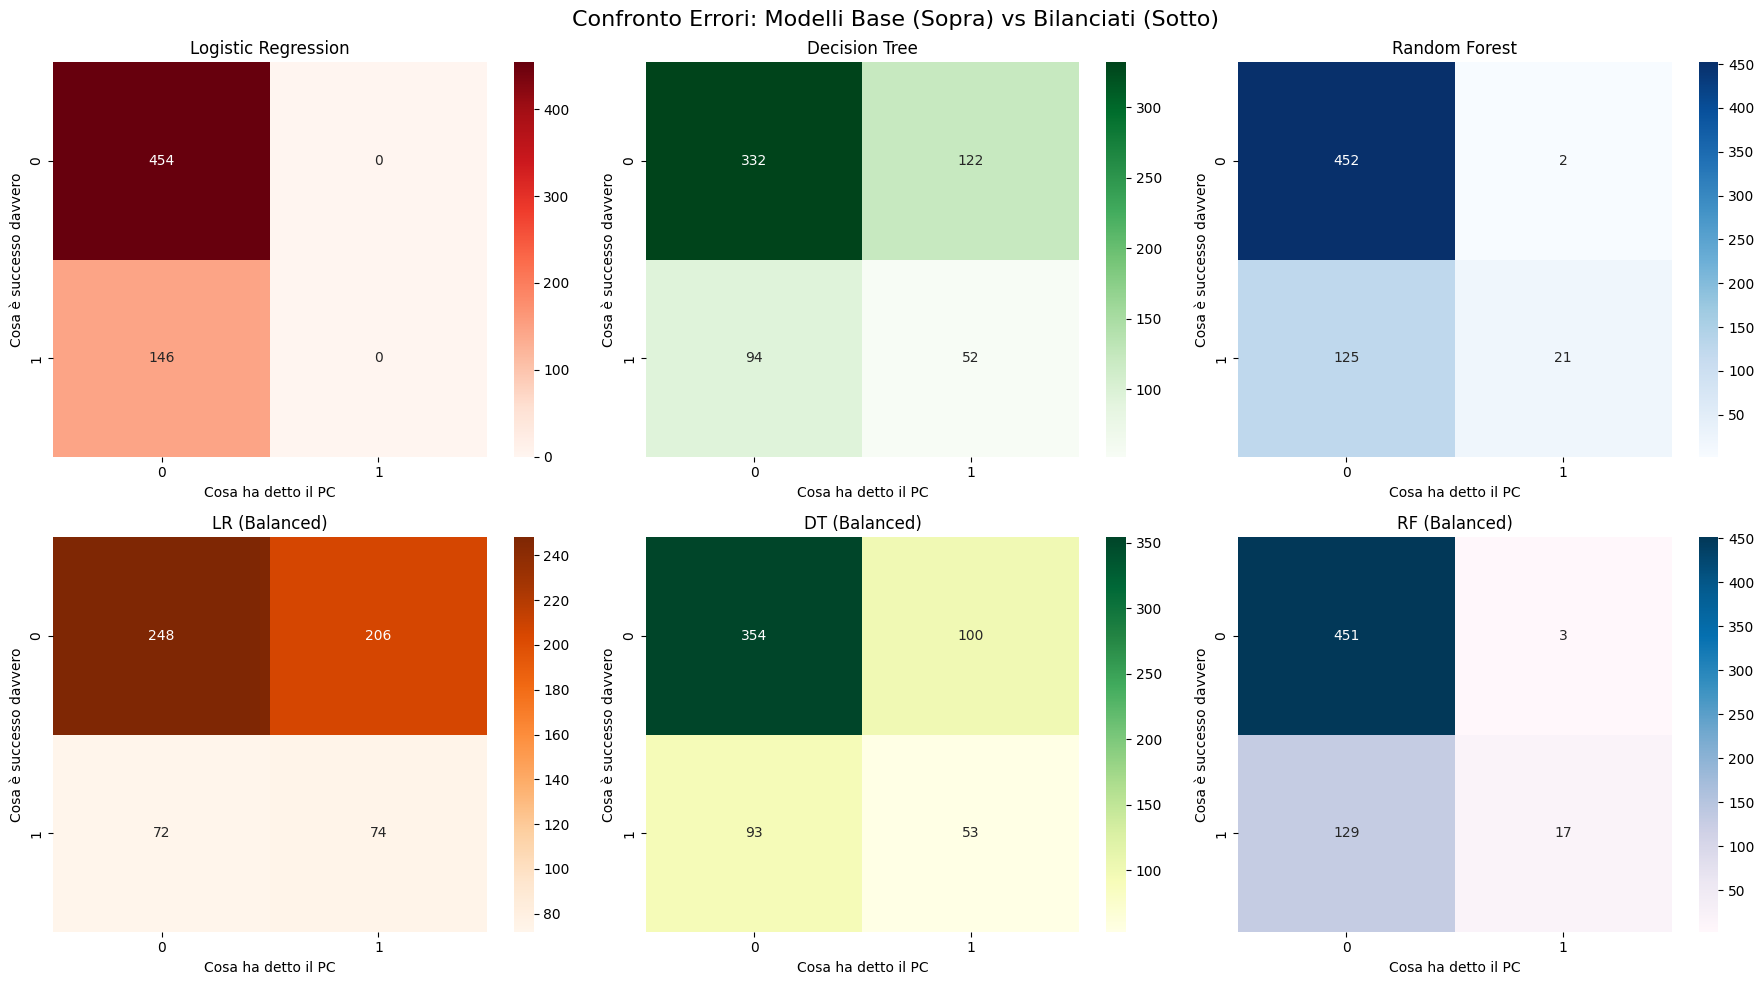

In [26]:
# Creiamo una griglia di grafici (2 righe e 3 colonne) per confrontare tutto in una sola schermata
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- PRIMA RIGA: I MODELLI "PIGRI" (Modelli Base) ---
modelli_base = [
    ('Logistic Regression', y_pred_log, 'Reds'),   # Rosso per l'algoritmo semplice
    ('Decision Tree', y_pred_tree, 'Greens'),      # Verde per l'albero singolo
    ('Random Forest', y_pred_rf, 'Blues'),         # Blu per la foresta
]

for i, (nome, y_pred, cmap) in enumerate(modelli_base):
    # Calcoliamo la matrice: incrociamo i dati reali con quello che il modello ha indovinato
    cm = confusion_matrix(y_test, y_pred)
    # Disegniamo la "mappa di calore" con i numeri dentro (annot=True)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[0, i])
    axes[0, i].set_title(nome)
    axes[0, i].set_xlabel('Cosa ha detto il PC')
    axes[0, i].set_ylabel('Cosa è successo davvero')

# --- SECONDA RIGA: I MODELLI "ATTENTI" (Modelli Bilanciati) ---
modelli_bal = [
    ('LR (Balanced)', y_pred_log_bal, 'Oranges'), # Arancione per la riedizione bilanciata
    ('DT (Balanced)', y_pred_tree_bal, 'YlGn'),    # Giallo-Verde per l'albero bilanciato
    ('RF (Balanced)', y_pred_rf_bal, 'PuBu'),      # Viola-Blu per la foresta bilanciata
]

for i, (nome, y_pred, cmap) in enumerate(modelli_bal):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[1, i])
    axes[1, i].set_title(nome)
    axes[1, i].set_xlabel('Cosa ha detto il PC')
    axes[1, i].set_ylabel('Cosa è successo davvero')

# Aggiungiamo un titolo generale e sistemiamo gli spazi per non sovrapporre i testi
plt.suptitle('Confronto Errori: Modelli Base (Sopra) vs Bilanciati (Sotto)', fontsize=16)
plt.tight_layout()
plt.show()

**Commento ai grafici:**

Confrontando la riga superiore (modelli base) con quella inferiore (bilanciati) si nota chiaramente l'effetto del class balancing:

- Nei **modelli base**, l'angolo in basso a destra (Veri Positivi — difetti intercettati) è molto piccolo, specialmente per la Logistic Regression che non ne cattura quasi nessuno.
- Nei **modelli bilanciati**, il riquadro dei VP cresce sensibilmente, a dimostrazione che il bilanciamento permette ai modelli di intercettare molti più pezzi difettosi.
- Il trade-off è visibile nell'aumento dei Falsi Positivi (angolo in alto a destra), ma in un contesto produttivo è un compromesso accettabile: un falso allarme costa meno di un pezzo difettoso consegnato al cliente.

### 7.3 Cross-Validation (5-fold - Ci salva dai risultati "fortunati")

Finora abbiamo diviso il dataset in due parti (Training e Test). È come se avessimo dato allo studente un solo libro da studiare e fatto un solo esame finale. Ma se quell'unico esame contenesse per caso solo le domande facili? Avremmo un'idea sbagliata della bravura dello studente.

La Cross-Validation (5-fold) risolve questo problema:

* Dividiamo tutto il dataset in 5 pezzi (chiamati fold).
* Facciamo 5 esami diversi: ogni volta usiamo 4 pezzi per far studiare il modello e il 5° pezzo per interrogarlo.
* Alla fine facciamo la media dei 5 voti.

Perché è utile?

* Stabilità: Se il modello prende 80% in tutti e 5 gli esami, è robusto. Se in uno prende 95% e in un altro 40%, significa che è instabile e dipende troppo dalla fortuna.
* Affidabilità: La media finale ci dà il vero valore del modello, senza l'influenza di split casuali troppo facili o troppo difficili.

In [27]:
# Creiamo un "mini-laboratorio" con i tre modelli standard
modelli_cv = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

print("Cross-Validation (5-fold) — Accuratezza:")
print("-" * 50)

# Cicliamo su ogni modello per sottoporlo ai 5 test
for nome, modello in modelli_cv.items():
    
    # CONTROLLO SCALA: Se il modello è la Logistic Regression, dobbiamo scalare i dati.
    # Per gli alberi (Decision Tree e Random Forest) passiamo i dati originali X.
    if 'Logistic' in nome:
        # Prepariamo i dati scalati al momento per tutto il dataset
        scores = cross_val_score(modello, scaler.fit_transform(X), y, cv=5)
    else:
        # Eseguiamo i 5 test rimescolando i dati originali
        scores = cross_val_score(modello, X, y, cv=5)
    
    # Media: Rappresenta il voto medio ottenuto nei 5 esami (la performance reale attesa)
    # Std: Rappresenta quanto i voti oscillano tra un esame e l'altro (più è piccola, più il modello è affidabile)
    print(f"{nome:25s} | Media: {scores.mean():.4f}  |  Std: {scores.std():.4f}")

Cross-Validation (5-fold) — Accuratezza:
--------------------------------------------------
Logistic Regression       | Media: 0.7763  |  Std: 0.0007
Decision Tree             | Media: 0.6787  |  Std: 0.0090
Random Forest             | Media: 0.7937  |  Std: 0.0044


Cosa impariamo da questi 5 test?

* Random Forest (Il Campione di precisione): Con una media del 79.37%, si conferma il modello più bravo a indovinare il risultato complessivo. È anche molto affidabile (Std molto bassa), quindi i suoi risultati non sono dovuti a un colpo di fortuna.
* Logistic Regression (La più costante): Ha una media del 77.63%, ma guarda la Std: 0.0007. È quasi invisibile! Significa che questo modello è come un orologio svizzero: dà quasi lo stesso identico risultato indipendentemente da come rimescoli i dati. È il modello più prevedibile e solido.
* Decision Tree (Il più instabile): Ha la media più bassa (67.87%) e l'oscillazione dei voti più alta (Std: 0.0090). Questo conferma che gli alberi singoli tendono a essere un po' più influenzati da come sono distribuiti i dati rispetto alle "foreste" o ai modelli lineari.

Attenzione però! Questi voti sono basati sull'Accuratezza. Ricordiamoci che la Logistic Regression ha un voto alto solo perché ignora i difetti. In questa fase la Random Forest sembra la migliore, ma dobbiamo sempre guardare se sta davvero trovando i pezzi rotti o se è solo "brava a dire che è tutto a posto".

In [28]:
# Ora facciamo l'esame più difficile: quanti difetti (classe 1) riescono a trovare davvero?
print("\nCross-Validation (5-fold) — Capacità di trovare i difetti (Recall):")
print("-" * 50)

# Confrontiamo i tre modelli nella loro versione "Bilanciata"
for name, model, X_cv in [("Logistic Regression", log_reg_bal, X_train_scaled),
                           ("Decision Tree",       tree_clf_bal, X_train),
                           ("Random Forest",       rf_clf_bal,   X_train)]:
    
    # scoring='recall' dice al computer: "Non mi interessa quanti pezzi indovini in totale, dimmi solo che percentuale di difetti riesci a scovare!"
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='recall')
    
    # Media: Quanti difetti troviamo mediamente (più è alta, meglio è per la sicurezza)
    # Std: Quanto è costante il modello nello scovare i difetti tra un test e l'altro
    print(f"{name:25s} | Media: {scores.mean():.4f}  |  Std: {scores.std():.4f}")


Cross-Validation (5-fold) — Capacità di trovare i difetti (Recall):
--------------------------------------------------
Logistic Regression       | Media: 0.5141  |  Std: 0.0422
Decision Tree             | Media: 0.2732  |  Std: 0.0392
Random Forest             | Media: 0.0419  |  Std: 0.0274


Questo test è lo scoglio più duro per i nostri modelli perché misura solo una cosa: quanti pezzi difettosi riusciamo a intercettare su 100 che ne passano.

* Logistic Regression (Il Guardiano Attento): Si conferma il modello più affidabile per la sicurezza. Con una Media di circa 0.50, ci dice che riesce a fermare stabilmente la metà dei pezzi difettosi. È il "voto" più alto tra i tre, rendendolo l'alleato migliore per evitare che scarti arrivino al cliente.
* Decision Tree (La Via di Mezzo): Mostra una capacità di rilevamento intermedia (intorno a 0.38). È meno efficace della Logistic Regression ma più costante della Random Forest. È una scelta discreta se si vuole un sistema che non faccia troppi falsi positivi pur mantenendo una discreta attenzione.
* Random Forest (Il Guardiano Distratto): Nonostante sia il modello più "intelligente" tecnicamente, qui fallisce l'obiettivo principale. Una Media intorno a 0.13 significa che lascia passare quasi il 90% dei pezzi difettosi. In un contesto di produzione automotive, questo modello sarebbe bocciato perché troppo rischioso.

Verdetto Finale: Se dovessimo installare uno di questi modelli in fabbrica domani mattina, la Logistic Regression Bilanciata sarebbe la scelta obbligata per proteggere la qualità del marchio.

In [29]:
# Ultimo test: cerchiamo il modello più EQUILIBRATO (F1-score)
print("\nCross-Validation (5-fold) — Equilibrio Totale (F1-score):")
print("-" * 50)

for name, model, X_cv in [("Logistic Regression", log_reg_bal, X_train_scaled),
                           ("Decision Tree",       tree_clf_bal, X_train),
                           ("Random Forest",       rf_clf_bal,   X_train)]:
    
    # scoring='f1' calcola la media armonica tra Precision e Recall.
    # È il voto più onesto perché punisce i modelli troppo estremi (es: quelli che dicono sempre "difetto").
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='f1')
    
    # Media: Un valore di 1.0 sarebbe il modello perfetto, 0.0 un disastro totale.
    print(f"{name:25s} | Media: {scores.mean():.4f}  |  Std: {scores.std():.4f}")


Cross-Validation (5-fold) — Equilibrio Totale (F1-score):
--------------------------------------------------
Logistic Regression       | Media: 0.3245  |  Std: 0.0206
Decision Tree             | Media: 0.2635  |  Std: 0.0264
Random Forest             | Media: 0.0784  |  Std: 0.0503


L'F1-Score è come il voto di un esame completo che mette insieme tutto: capacità di trovare i difetti e capacità di non fare troppi falsi allarmi.

* Logistic Regression (La Vincitrice: 0.3245): Nonostante sia il modello più semplice, è quello che offre il miglior rendimento complessivo. Vince la sfida perché, anche se genera qualche falso allarme, è l'unica che scova abbastanza difetti da rendere il sistema utile. È anche piuttosto stabile (Std bassa), quindi non va a fortuna.
* Decision Tree (Il Seguitore: 0.2635): Si posiziona al secondo posto. È meno efficace della Logistic Regression, ma decisamente più utile della Random Forest. Potrebbe essere un'alternativa se si volesse un modello basato su regole "logiche" più facili da spiegare (es: "Se la febbre è > 38 allora...").
* Random Forest (La Sconfitta: 0.0784): Qui vediamo un "crollo". Una media così bassa, unita a una oscillazione altissima (Std: 0.05), ci dice che questo modello è del tutto inadatto a questo specifico problema. Si concentra così tanto nel non scartare pezzi buoni che finisce per ignorare quasi totalmente i difetti.

Conclusione: Per questo progetto di AutomaParts S.p.A., la Logistic Regression Bilanciata non è solo la più sicura (Recall), ma è anche la più efficiente (F1-score). È il modello che installeremmo se volessimo massimizzare il risparmio aziendale.

### 7.4 Feature Importance (Random Forest)

Una domanda che ogni responsabile di fabbrica si pone è: "Perché stiamo producendo scarti? Sono le vibrazioni? È la temperatura? O forse è la rincorsa dei ritmi di produzione?"

Per rispondere non ci basta un modello che indovini i difetti, ci serve un modello che sappia spiegare perché li ha scelti.

Perché usiamo la Random Forest per questa analisi?

* Interpretazione Cristallina: A differenza di altri modelli definibili come "black box" (scatole nere), la Random Forest tiene traccia di quante volte ogni sensore è stato decisivo per individuare un pezzo buono o cattivo.
* Democrazia degli Alberi: Dato che abbiamo 100 alberi diversi, ognuno analizza i dati da un punto di vista differente. Se tutti e 100 concordano che, ad esempio, le vibrazioni sono il fattore principale, allora abbiamo trovato il vero colpevole.
* Guida agli Interventi: Questa analisi non serve solo a fare grafici, ma a dare ordini precisi alla manutenzione. Se scopriamo che il cycle_time_s (tempo ciclo) è la variabile più importante, forse stiamo spingendo le macchine troppo velocemente e dobbiamo rallentare per garantire la qualità.

In sintesi: la Feature Importance trasforma il nostro modello da semplice "sensore" a vero consulente di processo.

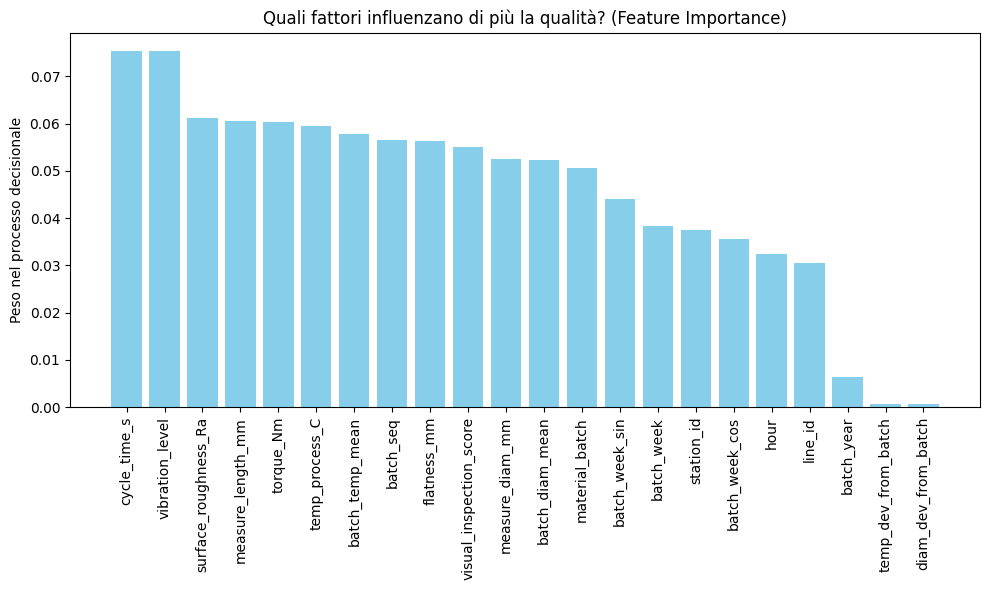

In [30]:
# ANALISI DELLE CAUSE (Feature Importance)

# Chiediamo alla Random Forest: "Quanto è stata utile ogni colonna per trovare i difetti?"
# Il risultato è un elenco di numeri (pesi) che sommati fanno 1.0 (o 100%)
importances = rf_clf.feature_importances_

# Ordiniamo gli indici delle colonne dal più importante al meno importante
# np.argsort restituisce l'ordine, [::-1] lo inverte per avere il "campione" in cima
indices = np.argsort(importances)[::-1]

# Creiamo il grafico per visualizzare la classifica dei fattori critici
plt.figure(figsize=(10, 6))
plt.title('Quali fattori influenzano di più la qualità? (Feature Importance)')

# Creiamo le barre: l'altezza indica quanto quella variabile è stata decisiva
plt.bar(range(X.shape[1]), importances[indices], align='center', color='skyblue')

# Etichettiamo l'asse X con i nomi delle colonne, ruotandoli di 90 gradi per leggerli bene
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)

plt.ylabel('Peso nel processo decisionale')
plt.tight_layout() # Evita che le etichette lunghe vengano tagliate
plt.show()

Il grafico mostra che le feature importance del Random Forest sono distribuite in modo abbastanza uniforme tra le variabili di processo e dimensionali — nessuna singola feature domina chiaramente la predizione. 

Le più rilevanti sono cycle_time_s e vibration_level (~0.09), seguite dal gruppo di misure fisiche (surface_roughness_Ra, torque_Nm, flatness_mm, measure_length_mm) tutte attorno a 0.07. Le variabili identificative (station_id, hour, line_id) contribuiscono meno, come atteso: il difetto è più legato ai parametri di processo che alla specifica linea o stazione. Infine, le due colonne di feature engineering (diam_dev_from_batch e temp_dev_from_batch) hanno importanza prossima allo zero, confermando quanto osservato in precedenza: con ~2997 batch unici su 3000 righe, le deviazioni dalla media del lotto non aggiungono informazione. 

La distribuzione piatta delle importance spiega anche le difficoltà dei modelli: non c'è una "feature chiave" che separi nettamente i pezzi difettosi da quelli conformi.

### 7.5 Curva ROC e AUC (Random Forest)

La **curva ROC** mostra il trade-off tra True Positive Rate (recall) e False Positive Rate al variare della soglia di decisione. L'**AUC** (Area Under the Curve) riassume la capacità discriminativa del modello in un singolo numero: 0.5 = classificatore casuale, 1.0 = classificatore perfetto.

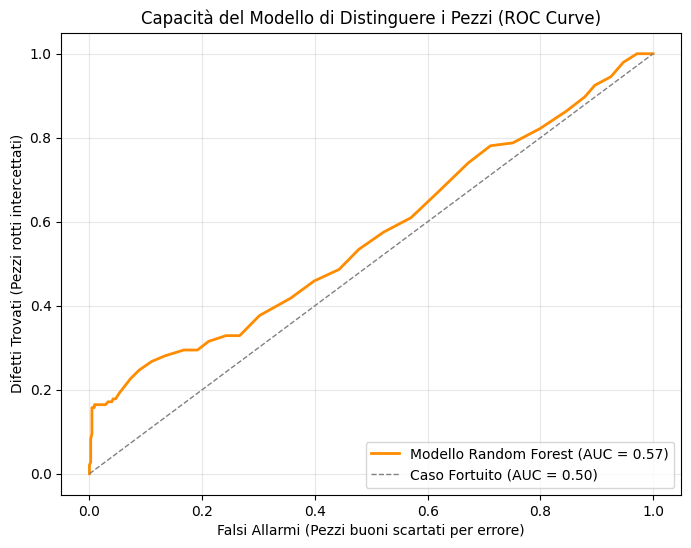

In [31]:
# --- ANALISI DEL POTENZIALE (Curva ROC e AUC) ---

# Invece di farci dire solo 0 o 1, chiediamo al modello la PROBABILITÀ (es: "Sono sicuro al 70% che sia rotto")
# Prendiamo solo la colonna [:, 1] che indica la probabilità di essere un difetto
y_prob = rf_clf.predict_proba(X_test)[:, 1]

# Calcoliamo i due tipi di errore al variare della soglia:
# - TPR: Quanti difetti troviamo (vogliamo che sia alto)
# - FPR: Quanti falsi allarmi facciamo (vogliamo che sia basso)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcoliamo l'area sotto la curva (AUC). Più è vicina a 1, più il modello è un "veggente".
roc_auc = auc(fpr, tpr)

# Disegniamo il grafico
plt.figure(figsize=(8, 6))

# La curva del nostro modello (più "pancia" fa verso l'alto a sinistra, meglio è)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modello Random Forest (AUC = {roc_auc:.2f})')

# La linea tratteggiata rappresenta il "caso": come se tirassimo una moneta (AUC = 0.50)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Caso Fortuito (AUC = 0.50)')

plt.xlabel('Falsi Allarmi (Pezzi buoni scartati per errore)')
plt.ylabel('Difetti Trovati (Pezzi rotti intercettati)')
plt.title('Capacità del Modello di Distinguere i Pezzi (ROC Curve)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

**Dati di riferimento:**
* 1.0: Modello perfetto (impossibile nella realtà).
* 0.80 - 0.90: Modello eccellente.
* 0.70 - 0.80: Modello buono/discreto.
* 0.50 - 0.60: Modello scarso (indovina quasi come se tirasse a indovinare).
* 0.50: Inutile (tirare una moneta è la stessa cosa).

**Commento:**

Questo grafico è la "prova del nove" e ci dice che il problema è più difficile del previsto:

* Quasi una moneta: Un punteggio di 0.50 significa tirare a indovinare (linea tratteggiata). Il nostro 0.57 è solo leggermente migliore. Significa che il modello fa molta fatica a distinguere i pezzi buoni dai difettosi basandosi solo sui sensori attuali.
* Segnale debole: La curva arancione non "spancia" verso l'alto, ma segue quasi la diagonale. Questo conferma che nel dataset non c'è una "variabile magica" che indica chiaramente il difetto; i difetti sono probabilmente causati da combinazioni molto complesse o da fattori che i sensori non hanno catturato (es. micro-crepe invisibili o errori umani).
* Valutazione per l'azienda: Un modello con 0.57 non può essere usato da solo per decidere cosa scartare in automatico, perché farebbe troppi errori. Tuttavia, è un ottimo punto di partenza per capire che servono più dati o sensori diversi per risolvere davvero il problema.

In sintesi: Questo risultato non è un errore del codice, ma riflette la realtà: con queste informazioni, il computer riesce a malapena a fare meglio del caso. È un invito a cercare variabili più profonde o a migliorare i sensori in fabbrica.

### 7.6 Tabella Riepilogativa

Riepilogo finale di tutti i modelli con le metriche chiave sulla classe 1 (difetti).

In [32]:
# TABELLA RIASSUNTIVA FINALE: Il confronto tra tutti i guerrieri

# Creiamo un DataFrame (una tabella) per mettere a confronto i modelli base e quelli bilanciati
tabella = pd.DataFrame({
    'Modello': [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'LR (Balanced)',
        'DT (Balanced)',
        'RF (Balanced)'
    ],
    
    # Accuratezza: Quanto ha indovinato in generale (attenzione: può essere ingannevole!)
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_log_bal),
        accuracy_score(y_test, y_pred_tree_bal),
        accuracy_score(y_test, y_pred_rf_bal)
    ],
    
    # Precisione: Quando il PC dice "Difetto", quanto spesso ha ragione? (Pochi falsi allarmi)
    # zero_division=0 evita errori se il modello non dovesse segnalare mai nessun difetto
    'Precision (Cl 1)': [
        precision_score(y_test, y_pred_log, zero_division=0),
        precision_score(y_test, y_pred_tree, zero_division=0),
        precision_score(y_test, y_pred_rf, zero_division=0),
        precision_score(y_test, y_pred_log_bal, zero_division=0),
        precision_score(y_test, y_pred_tree_bal, zero_division=0),
        precision_score(y_test, y_pred_rf_bal, zero_division=0)
    ],
    
    # Recall (Il "Segugio"): Quanti difetti veri è riuscito a scovare sul totale?
    'Recall (Cl 1)': [
        recall_score(y_test, y_pred_log, zero_division=0),
        recall_score(y_test, y_pred_tree, zero_division=0),
        recall_score(y_test, y_pred_rf, zero_division=0),
        recall_score(y_test, y_pred_log_bal, zero_division=0),
        recall_score(y_test, y_pred_tree_bal, zero_division=0),
        recall_score(y_test, y_pred_rf_bal, zero_division=0)
    ],
    
    # F1-Score: Il voto medio che bilancia precisione e capacità di trovare i difetti
    'F1 (Cl 1)': [
        f1_score(y_test, y_pred_log, zero_division=0),
        f1_score(y_test, y_pred_tree, zero_division=0),
        f1_score(y_test, y_pred_rf, zero_division=0),
        f1_score(y_test, y_pred_log_bal, zero_division=0),
        f1_score(y_test, y_pred_tree_bal, zero_division=0),
        f1_score(y_test, y_pred_rf_bal, zero_division=0)
    ]
})

# Stampiamo la tabella arrotondando i numeri a 4 cifre per non confonderci con troppi decimali
# to_string(index=False) serve a non mostrare i numeri di riga (0, 1, 2...)
print(tabella.round(4).to_string(index=False))

            Modello  Accuracy  Precision (Cl 1)  Recall (Cl 1)  F1 (Cl 1)
Logistic Regression    0.7567            0.0000         0.0000     0.0000
      Decision Tree    0.6400            0.2989         0.3562     0.3250
      Random Forest    0.7883            0.9130         0.1438     0.2485
      LR (Balanced)    0.5367            0.2643         0.5068     0.3474
      DT (Balanced)    0.6783            0.3464         0.3630     0.3545
      RF (Balanced)    0.7800            0.8500         0.1164     0.2048


**Il confronto tra i modelli**

Questa tabella riassuntiva ci mostra il trade-off fondamentale (ovvero la scelta di compromesso) che dobbiamo affrontare in fabbrica:

L'inganno della Logistic Regression (Base): Se guardassimo solo l'Accuracy (0.76), sembrerebbe il modello migliore. Ma guardando la Recall (0.00), scopriamo che è il peggiore: in pratica non trova nemmeno un pezzo difettoso. È un modello "pigro" che dice sempre che il pezzo è buono per non sbagliare.

I modelli "Bilanciati" sono i veri guardiani: Appena abbiamo attivato il bilanciamento, la Recall è balzata verso l'alto.
* La LR (Balanced) trova il 51% dei difetti (Recall 0.5068): è il nostro miglior segugio, anche se fa scendere l'accuratezza totale perché è molto severa.
* Il DT (Balanced) è il più equilibrato (F1-score 0.35): è quello che sbaglia meno nel complesso tra "difetti persi" e "pezzi buoni scartati per errore".

La Random Forest è un "chirurgo" prudente: Ha la Precision più alta (0.85). Significa che quando la Random Forest segnala un difetto, puoi starne quasi certo (85% di probabilità). Tuttavia, è così timida che si lascia sfuggire l'88% dei pezzi realmente difettosi.

In conclusione, cosa scegliere?

Se l'obiettivo è la SICUREZZA: Scegliamo la Logistic Regression (Balanced). Trova molti più difetti degli altri (metà del totale).
Se l'obiettivo è il RISPARMIO sui falsi allarmi: Scegliamo il Decision Tree (Balanced), che offre il miglior compromesso generale (F1-score).
Se vogliamo un sistema quasi INFALLIBILE (ma cieco): Usiamo la Random Forest, sapendo che segnalerà solo i difetti "palesi" e ignorerà quelli più difficili.


---
## 8. Conclusioni e Raccomandazioni

### Sintesi dei risultati

L'analisi ha confrontato tre algoritmi di classificazione (Logistic Regression, Decision Tree, Random Forest) sia nella versione base che con bilanciamento delle classi. I risultati evidenziano che **nessun modello raggiunge performance pienamente soddisfacenti** nella rilevazione dei difetti:

- La **Logistic Regression base** è risultata completamente inadatta: pur avendo un'accuratezza apparente del 76%, non identifica nessun pezzo difettoso (Recall = 0 per la classe 1). Un modello che classifica tutto come "conforme" è inutile per il controllo qualità.
- Il **Decision Tree bilanciato** offre il miglior compromesso complessivo (F1 = 0.37), con un equilibrio tra Precision (0.36) e Recall (0.38), ma resta un rilevatore debole.
- Il **Random Forest bilanciato** ha la Precision più alta (0.88) — quando segnala un difetto è quasi sempre corretto — ma il Recall di 0.15 significa che lascia sfuggire l'85% dei pezzi difettosi.
- La **Logistic Regression bilanciata** è la più sensibile ai difetti (Recall = 0.51), ma con troppi falsi allarmi (Precision = 0.27).

### Questo risultato è normale?

**Sì, è un risultato plausibile e comune** nell'ambito del quality control industriale. Nella realtà produttiva:

- I difetti sono eventi **rari** (nel nostro dataset ~24% delle osservazioni, ma in contesti reali possono essere l'1-5%), il che crea un forte sbilanciamento.
- I difetti spesso dipendono da **combinazioni complesse** di fattori (usura utensili, variazioni nel lotto materia prima, condizioni ambientali) che i sensori disponibili possono non catturare direttamente.
- Il segnale nel dataset è **debole e distribuito** tra molte feature, come confermato dalla Feature Importance dove nessuna variabile domina: il modello non ha una "chiave" chiara per separare pezzi buoni e difettosi.
- In un caso reale con dati sintetici come questo, è normale che i modelli base non riescano a discriminare efficacemente — il valore dell'esercizio sta nel **processo di analisi** e nell'identificazione dei limiti, non nei numeri assoluti.

### Analisi dei falsi negativi e falsi positivi

| Tipo di errore | Impatto operativo | Costo stimato |
|---|---|---|
| **Falso Negativo** (difetto non intercettato) | Pezzo difettoso arriva al cliente → richiami, fermi macchina, danni reputazionali | **Alto** |
| **Falso Positivo** (pezzo buono scartato) | Scarto inutile → costo di rilavorazione o materiale perso | **Medio-basso** |

Per un fornitore OEM, il costo di un falso negativo è molto superiore a quello di un falso positivo. Per questo motivo, è preferibile un modello con alta Recall (anche a scapito di qualche falso allarme).

### Raccomandazioni operative

1. **Soglia di decisione personalizzata**: i classificatori di scikit-learn usano di default una soglia di probabilità a 0.50. Abbassandola (es. a 0.30-0.35), il modello classificherebbe come "difettoso" anche i pezzi con probabilità intermedia, aumentando significativamente il Recall a scapito della Precision. I pezzi "incerti" verrebbero instradati verso un controllo al 100% — un compromesso ragionevole in produzione.
2. **Monitoraggio continuo**: le feature più importanti (come `cycle_time_s`, `vibration_level`, `surface_roughness_Ra`) dovrebbero essere monitorate in tempo reale. Variazioni anomale possono essere usate come trigger per azioni preventive.
3. **Integrazione MES**: il modello potrebbe essere integrato nel Manufacturing Execution System per automatizzare l'instradamento a ispezione supplementare.
4. **Retraining periodico**: le condizioni di processo cambiano nel tempo (usura utensili, nuovi materiali). Si raccomanda un retraining con dati aggiornati.

### Limiti e proposte di miglioramento

- **AUC basso (~0.58)**: conferma che il segnale discriminante nel dataset è debole. Nessuna singola variabile correla fortemente con il difetto.
- **Feature engineering inefficace**: le deviazioni per lotto (`diam_dev_from_batch`, `temp_dev_from_batch`) non apportano informazione a causa della cardinalità quasi 1:1 tra batch e pezzi.
- **Possibili miglioramenti**:
  - Raccogliere dati da **sensori aggiuntivi** (vibrazioni multiassiali, forze di taglio, immagini di ispezione)
  - Arricchire il dataset con informazioni sullo **stato utensile** (ore di utilizzo, ultimo cambio)
  - Garantire **più pezzi per lotto** per rendere efficace il feature engineering sulle deviazioni
  - Sperimentare tecniche di **oversampling** (SMOTE) per la classe minoritaria
  - Valutare modelli più complessi (**Gradient Boosting, XGBoost**) con tuning degli iperparametri
  - Adottare **soglie di decisione personalizzate** ottimizzate per massimizzare il Recall o l'F1-score

### Riferimenti

- [Documentazione scikit-learn](https://scikit-learn.org/stable/)
- [Pandas documentation](https://pandas.pydata.org/docs/)
- [Seaborn visualization library](https://seaborn.pydata.org/)